<a href="https://colab.research.google.com/github/0Sensei2/Deep-Learning/blob/main/Multilabel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
# Standard Library
import os
# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
# Progress Bar
from tqdm import tqdm
# TensorFlow and Keras (Unified)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
                                     BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from matplotlib.pyplot import imshow
from PIL import Image

In [3]:
os.environ["KAGGLE_USERNAME"] = "sensei02" # Ganti dengan username Kaggle Anda
os.environ["KAGGLE_KEY"] = "77bc9cbb4599a9193b7c2204d5d9434b" # Ganti dengan key yang ada di kaggle.json

In [14]:
!kaggle datasets download -d sensei02/datasetrandom

Dataset URL: https://www.kaggle.com/datasets/sensei02/datasetrandom
License(s): unknown


In [15]:
# prompt: unzip file movie-classifier.zip

!unzip datasetrandom.zip


Archive:  datasetrandom.zip
replace DatasetMultilabel_DevidPratama_202255202113/Gambar1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DatasetMultilabel_DevidPratama_202255202113/Gambar1.jpeg  
replace DatasetMultilabel_DevidPratama_202255202113/Gambar10.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace DatasetMultilabel_DevidPratama_202255202113/Gambar10.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y,a
  inflating: DatasetMultilabel_DevidPratama_202255202113/Gambar10.jpeg  
replace DatasetMultilabel_DevidPratama_202255202113/Gambar100.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DatasetMultilabel_DevidPratama_202255202113/Gambar100.jpeg  
replace DatasetMultilabel_DevidPratama_202255202113/Gambar101.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DatasetMultilabel_DevidPratama_202255202113/Gambar101.jpeg  
replace DatasetMultilabel_DevidPratama_202255202113/Gambar102.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error

In [16]:
df = pd.read_csv('/content/traindataset_DevidPratama_202255202113.csv')
pd.set_option('display.max_columns', None)
df.head()


,Id,Object,Kacamata,Cat Kuku,Gelas,Pena
0,Gambar1,"['Kacamata','Cat Kuku','Pena','Gelas']",1,1,1,1
1,Gambar2,"['Kacamata','Cat Kuku','Pena','Gelas']",1,1,1,1
2,Gambar3,"['Kacamata','Cat Kuku','Pena','Gelas']",1,1,1,1
3,Gambar4,"['Kacamata','Cat Kuku','Pena','Gelas']",1,1,1,1
4,Gambar5,"['Kacamata','Cat Kuku','Pena','Gelas']",1,1,1,1


In [18]:
SIZE = 200
X_dataset = []
image_directory = '/content/DatasetMultilabel_DevidPratama_202255202113'
for i in tqdm(range(df.shape[0])):
    img = image.load_img(image_directory + '/' + df['Id'][i]+'.jpeg', target_size=(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.0
    X_dataset.append(img)

X = np.array(X_dataset)

100%|██████████| 300/300 [00:02<00:00, 118.49it/s]


Gambar150
['Gelas','Gelas','Gelas']


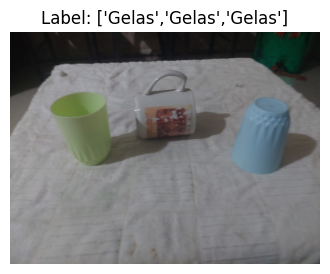

In [20]:
print(df['Id'][149])
print(df['Object'][149])
image_path = os.path.join(image_directory, df['Id'][149] + '.jpeg')
img = Image.open(image_path)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"Label: {df['Object'][149]}")
plt.axis('off')
plt.show()


In [21]:
y = np.array(df.drop(['Id', 'Object'], axis=1))

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=20)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 30, Test: 30


In [22]:
input_shape = (200, 200, 3)
num_classes = 4
multi_label = True

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

output_activation = 'sigmoid' if multi_label else 'softmax'
loss_fn = 'binary_crossentropy' if multi_label else 'categorical_crossentropy'

output = Dense(num_classes, activation=output_activation)(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=[tf.keras.metrics.AUC(multi_label=True, name='auc')])

model.summary()

<ipython-input-22-96774045ec4f>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 100, 100,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 100, 100,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 100, 100,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 100, 100,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 100, 100,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 100, 100,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 100, 100,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 100, 100,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 101, 101,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 50, 50,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 50, 50,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 50, 50,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 50, 50,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    batch_size=64)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - auc: 0.5207 - loss: 0.7977 - val_auc: 0.6354 - val_loss: 0.5787
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - auc: 0.6758 - loss: 0.5572 - val_auc: 0.7364 - val_loss: 0.4756
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - auc: 0.7817 - loss: 0.4827 - val_auc: 0.8164 - val_loss: 0.4577
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - auc: 0.8327 - loss: 0.4169 - val_auc: 0.8645 - val_loss: 0.3780
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - auc: 0.8767 - loss: 0.3579 - val_auc: 0.8911 - val_loss: 0.3328
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - auc: 0.9147 - loss: 0.2853 - val_auc: 0.9178 - val_loss: 0.3134
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - auc: 0.9231 - loss: 0.2872 - val_auc: 0.9332 - val_loss: 0.2869
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.9402 - loss: 0.2564 - val_auc: 0.9412 - val_loss: 0.2427
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.9470 - loss: 0.2315 - v

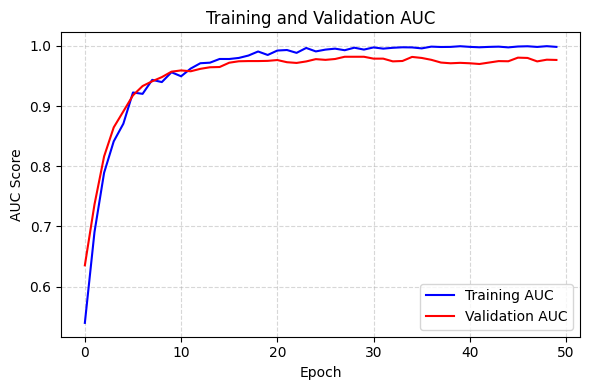

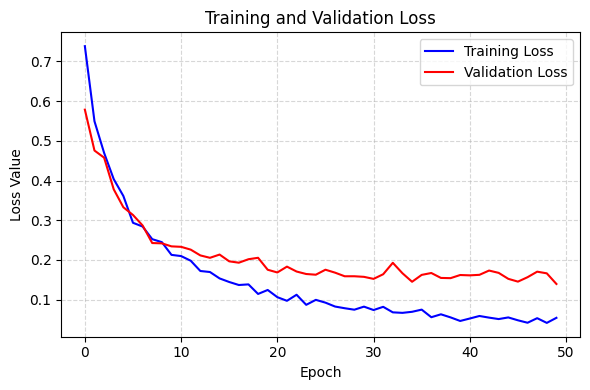

In [24]:
# Ambil data dari history untuk plotting
auc_values = history.history['auc']
val_auc_values = history.history['val_auc']
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs_range = range(len(auc_values))

# Plot AUC
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, auc_values, color='blue', linestyle='-', label='Training AUC')
plt.plot(epochs_range, val_auc_values, color='red', linestyle='-', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, loss_values, color='blue', linestyle='-', label='Training Loss')
plt.plot(epochs_range, val_loss_values, color='red', linestyle='-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Gelas (1.0)
Cat Kuku (0.999)
Pena (0.986)
Kacamata (0.00607)


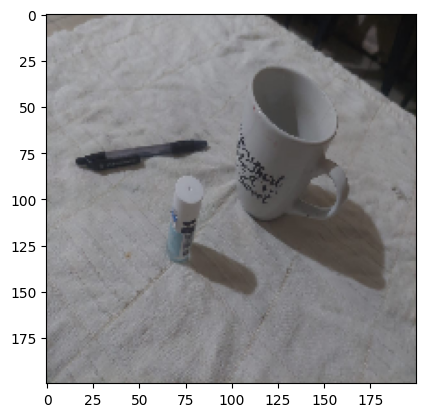

In [29]:
img = image.load_img('/content/DatasetMultilabel_DevidPratama_202255202113/Gambar121.jpeg', target_size=(SIZE,SIZE,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[2:])
proba = model.predict(img)
sorted_categories = np.argsort(proba[0])[:-11:-1]

for i in range(4):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

In [30]:
loss, auc_score = model.evaluate(X_test, y_test)
print("AUC = ", (auc_score * 100.0), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - auc: 0.9716 - loss: 0.2318
AUC =  97.1563994884491 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:
              precision    recall  f1-score   support

    Kacamata     1.0000    1.0000    1.0000        24
    Cat Kuku     0.8000    1.0000    0.8889        20
       Gelas     1.0000    0.8636    0.9268        22
        Pena     0.8636    1.0000    0.9268        19

   micro avg     0.9111    0.9647    0.9371        85
   macro avg     0.9159    0.9659    0.9356        85
weighted avg     0.9225    0.9647    0.9386        85
 samples avg     0.9111    0.9500    0.9227        85



<Figure size 1200x1000 with 0 Axes>

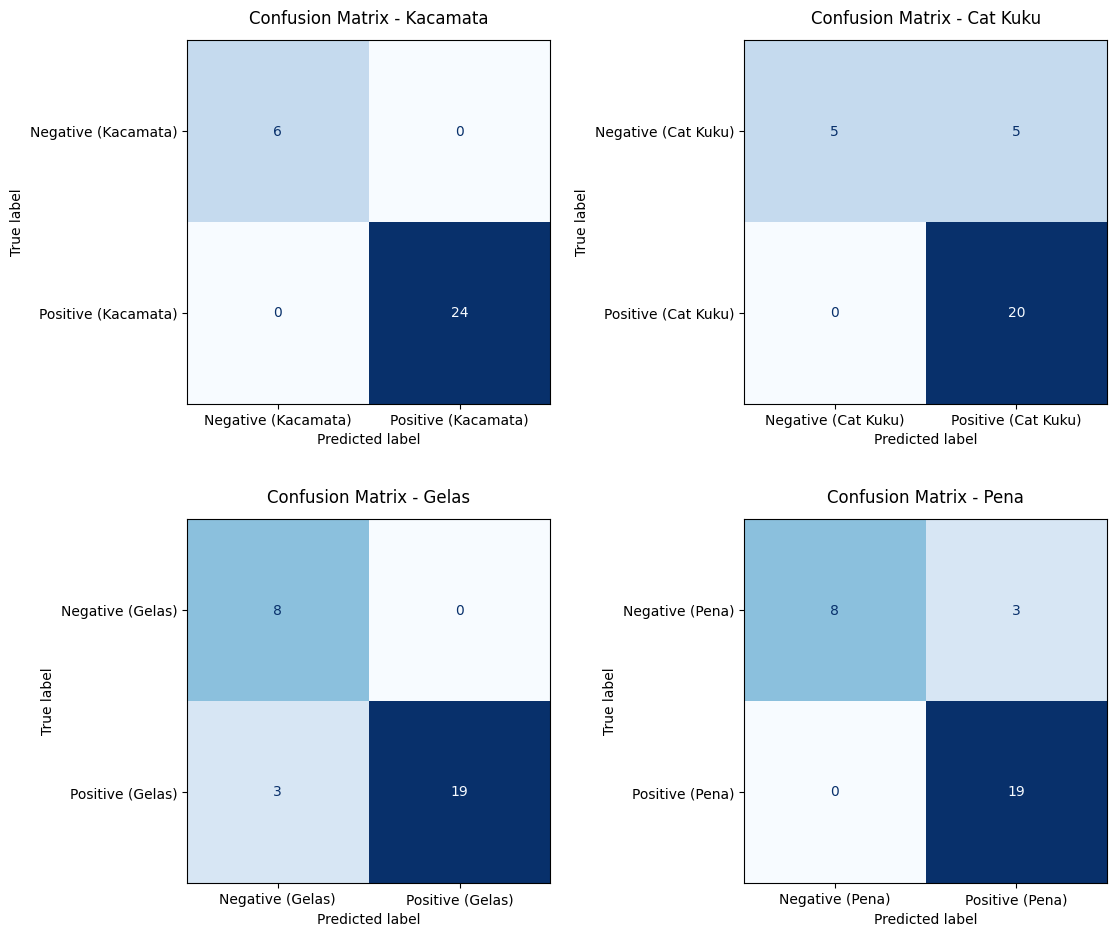

In [31]:
# Prediksi
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

# Laporan klasifikasi
target_labels = df.columns[2:]
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes,
                          target_names=target_labels,
                          zero_division=0,
                          digits=4))

# Plot Confusion Matrix untuk setiap label
plt.figure(figsize=(12, 10))
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for idx, label in enumerate(target_labels):
    # Get confusion matrix for current label
    current_cm = multilabel_confusion_matrix(y_test, predicted_classes)[idx]

    # Create display
    matrix_display = ConfusionMatrixDisplay(
        confusion_matrix=current_cm,
        display_labels=[f'Negative ({label})', f'Positive ({label})']
    )

    # Plot on corresponding subplot
    matrix_display.plot(ax=axs[idx//2, idx%2],
                      cmap='Blues',
                      values_format='d',
                      colorbar=False)
    axs[idx//2, idx%2].set_title(f'Confusion Matrix - {label}', pad=12)

plt.tight_layout(pad=3.0)
plt.show()